In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D,BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB3


import os
import glob

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D1030 02:23:41.775926712      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1030 02:23:41.775951905      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1030 02:23:41.775955475      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1030 02:23:41.775958237      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1030 02:23:41.775960596      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1030 02:23:41.775965912      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1030 02:23:41.775968485      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1030 02:23:41.

In [3]:
train = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train.csv')
test = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')

In [4]:
class Config:
    
    seed = 44
    num_classes = 11
    class_list = [0,1,2,3,4,5,6,7,8,9,10]
    batch_size = 32
    n_epochs = 15
    drop_rate = 0.4
   
    #scheduler = 'CosineAnnealingLR'
    
    scheduler_params = {           
                    'ReduceLROnPlateau': 
                        {
                            'monitor':'val_loss',
                            'mode':'max',
                            'factor':0.5,
                            'patience':2,
                            'threshold':0.0001,
                            'threshold_mode':'rel',
                            'cooldown':0,
                            'min_lr':1e-5,
                            'eps':1e-08,
                            'verbose':True
                        },
                
                }
    
    
    # optimizer
    optimizer = tf.keras.optimizers.Adam(lr = 1e-4)

    # criterion
    loss = 'binary_crossentropy'
    
    target_size_dim = 300
    
    metrics = tf.keras.metrics.AUC(multi_label=True)
    
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', epsilon=0.0001, 
                                       cooldown=5, min_lr=0.00001)
    
    checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = False)

    checkpoint_last = ModelCheckpoint('last_model.hdf5', 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=False, 
                             mode= 'min', 
                             save_weights_only = False)


    early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=5)
    
    labels = [
                'ETT - Abnormal',
                'ETT - Borderline',
                'ETT - Normal',
                'NGT - Abnormal',
                'NGT - Borderline',
                'NGT - Incompletely Imaged',
                'NGT - Normal', 
                'CVC - Abnormal',
                'CVC - Borderline',
                'CVC - Normal',
                'Swan Ganz Catheter Present'
            ]
    
    paths = {
                'train_path':'../input/ranzcr-clip-trainset-256x256',
                'test_path': '../input/siim-isic-melanoma-classification/jpeg/test',
                'csv_path': '../input/ranzcr-clip-catheter-line-classification/train.csv',
                'model_weight_path_folder': '../input/tfkerasefficientnetimagenetnotop'
            }

In [5]:
np.random.seed(Config.seed)
tf.random.set_seed(Config.seed)
os.environ['PYTHONHASHSEED'] = str(Config.seed)

In [6]:
df = pd.read_csv(Config.paths['csv_path'])
df.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [7]:
print('Number of Records: {} and Number of Patients: {}'.format(len(df), df['PatientID'].nunique()))

Number of Records: 30083 and Number of Patients: 3255


In [8]:
df['PatientID'].value_counts()

PatientID
05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
0651366c7      1
8af38b60c      1
aa79ba223      1
257186123      1
f46237081      1
Name: count, Length: 3255, dtype: int64

In [9]:
df['path'] = '../input/ranzcr-clip-catheter-line-classification/train/' + df['StudyInstanceUID']+'.jpg'

In [10]:
X_train, X_valid = train_test_split(df, test_size = 0.1, random_state=Config.seed, shuffle=True)

In [11]:
Train_df = tf.data.Dataset.from_tensor_slices((X_train.path.values, X_train[Config.labels].values))

Valid_df = tf.data.Dataset.from_tensor_slices((X_valid.path.values, X_valid[Config.labels].values))

In [12]:
for path, label in Train_df.take(2):
    print ('Path: {}, Label: {}'.format(path, label))

Path: b'../input/ranzcr-clip-catheter-line-classification/train/1.2.826.0.1.3680043.8.498.77450987024033881392380244092093127658.jpg', Label: [0 0 0 0 0 0 0 0 1 0 0]
Path: b'../input/ranzcr-clip-catheter-line-classification/train/1.2.826.0.1.3680043.8.498.92657683760527156508749101577829076177.jpg', Label: [0 0 0 0 0 0 0 0 1 0 0]


In [13]:
def process_data_train(image_path, label):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, [Config.target_size_dim, Config.target_size_dim])
    #img = tf.image.per_image_standardization(img)
    
    return img, label

def process_data_valid(image_path, label):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [Config.target_size_dim, Config.target_size_dim])
    
    return img, label

In [14]:
Train_df = Train_df.map(process_data_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
Valid_df = Valid_df.map(process_data_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)

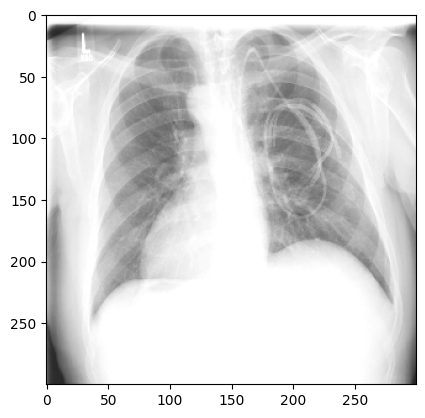

Image shape:  (300, 300, 3)
Label:  CVC - Borderline


In [15]:
for image, label in Train_df.take(1):
    
    plt.imshow(image.numpy().astype('uint8'))
    plt.show()
    print("Image shape: ", image.numpy().shape)
    print("Label: ", Config.labels[np.argmax(label.numpy())])

In [16]:
def configure_for_performance(ds, batch_size = Config.batch_size):
    
    ds = ds.cache('/kaggle/dump.tfcache') 
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=1024)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

train_ds_batch = configure_for_performance(Train_df)
valid_ds_batch = Valid_df.batch(Config.batch_size*2)
image_batch, label_batch = next(iter(train_ds_batch))

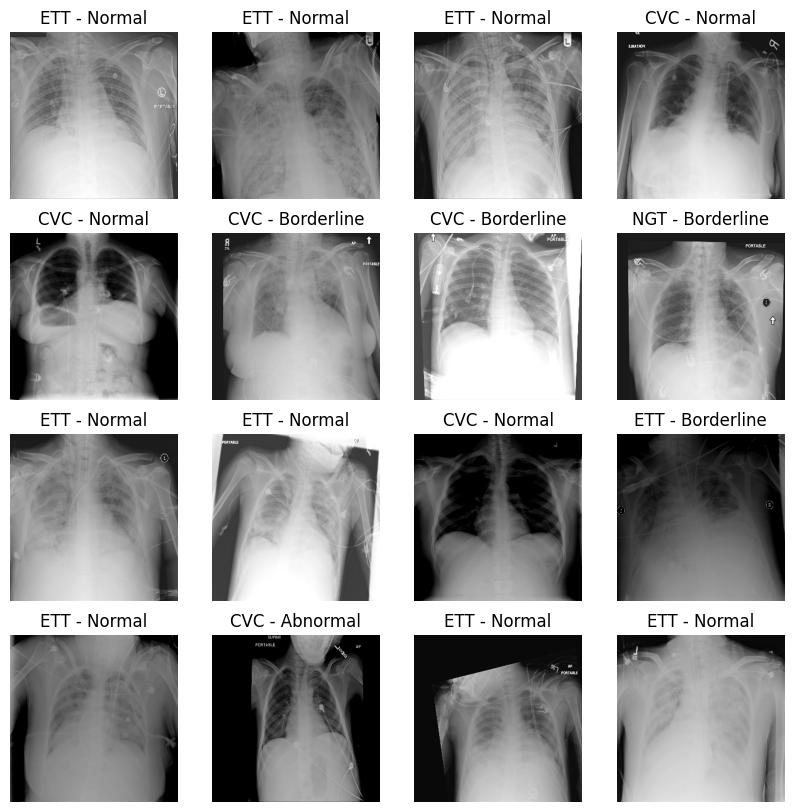

In [17]:
plt.figure(figsize=(10, 10))
for i in range(16):
    
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = Config.labels[np.argmax(label_batch[i].numpy())]
    plt.title(label)
    plt.axis("off")

In [18]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.05, interpolation='nearest'),
    ]
)

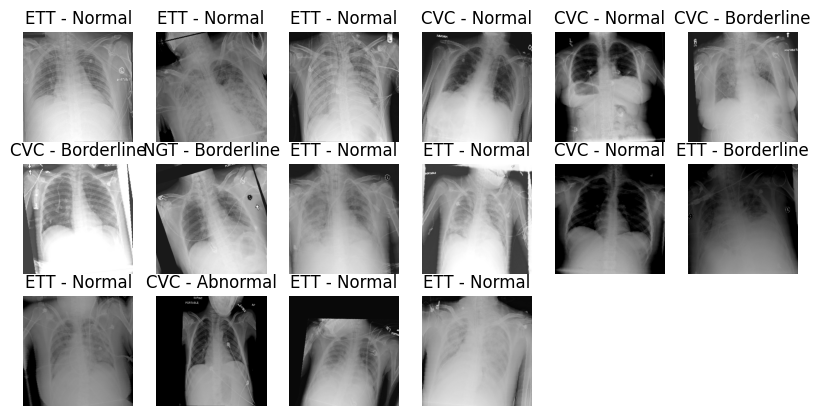

In [19]:
plt.figure(figsize=(10, 10))

for i in range(16):
    
    augmented_images = data_augmentation(image_batch)
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    label = Config.labels[np.argmax(label_batch[i].numpy())]
    plt.title(label)
    plt.axis("off")

In [20]:
def load_pretrained_model(weights_path, drop_connect, target_size_dim, layers_to_unfreeze=5):
    
    model = EfficientNetB3(
            weights=None, 
            include_top=False, 
            drop_connect_rate=0.4
        )
    
    model.load_weights(weights_path)
    
    model.trainable = True

    return model

def build_my_model(base_model, optimizer, metrics, loss):
    
    inputs = tf.keras.layers.Input(shape=(Config.target_size_dim, Config.target_size_dim, 3))
    x = data_augmentation(inputs)
    outputs_eff = base_model(x)
    global_avg_pooling = GlobalAveragePooling2D()(outputs_eff)
    dense_1= Dense(256)(global_avg_pooling)
    bn_1 = BatchNormalization()(dense_1)
    activation = Activation('relu')(bn_1)
    dropout = Dropout(0.3)(activation)
    dense_2 = Dense(len(config.labels), activation='sigmoid')(dropout)

    my_model = tf.keras.Model(inputs, dense_2)
    
    my_model.compile(
        optimizer=Config.optimizer,
        loss=Config.loss,
        metrics=Config.metrics
    )
    
    return my_model

In [21]:
config = Config

In [22]:
model_weights_path = '/kaggle/input/effificentnet-pretrained-model/efficientnetb3.h5'
model_weights_path

'/kaggle/input/effificentnet-pretrained-model/efficientnetb3.h5'

In [23]:
base_model = load_pretrained_model(model_weights_path, Config.drop_rate, Config.target_size_dim)

my_model = build_my_model(base_model, Config.optimizer, metrics = [Config.metrics], loss=Config.loss)

my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                               

In [24]:
callbacks_list = [config.checkpoint, config.checkpoint_last, config.early, config.reduceLROnPlat]

In [25]:
steps_per_epoch = len(X_train) // config.batch_size

history = my_model.fit(
                          train_ds_batch, 
                          validation_data = valid_ds_batch, 
                          epochs = 4, 
                          callbacks = callbacks_list,
                        verbose=1,
                          steps_per_epoch = steps_per_epoch
                      )

Epoch 1/2
150/150 [==============================] - ETA: 0s - loss: 0.3101 - auc: 0.6680WARNING:tensorflow:Can save best model only with val_loss available, skipping.



Epoch 1: saving model to last_model.hdf5


150/150 [==============================] - 933s 6s/step - loss: 0.3101 - auc: 0.6680 - lr: 0.0010
Epoch 2/2
150/150 [==============================] - ETA: 0s - loss: 0.2487 - auc: 0.7465WARNING:tensorflow:Can save best model only with val_loss available, skipping.



Epoch 2: saving model to last_model.hdf5


150/150 [==============================] - 856s 6s/step - loss: 0.2487 - auc: 0.7465 - lr: 0.0010


I have trained on training datasets , you will required to run with validation and with more epochs and will get more accuracy

In [26]:
pred_valid_y = my_model.predict(valid_ds_batch, verbose = True, workers=4)
pred_valid_y_labels = np.argmax(pred_valid_y, axis=-1)

48/48 [==============================] - 143s 3s/step


In [30]:
valid_labels = np.concatenate([y.numpy() for x, y in valid_ds_batch], axis=0)

In [28]:
test_images = glob.glob('../input/ranzcr-clip-catheter-line-classification/test/*.jpg')
df_test = pd.DataFrame(np.array(test_images), columns=['Path'])
df_test.head()
test_ds = tf.data.Dataset.from_tensor_slices((df_test.Path.values))
def process_test(image_path):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [config.target_size_dim, config.target_size_dim])
    
    return img
    
test_ds = test_ds.map(process_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(config.batch_size*2)

In [29]:
pred_y = my_model.predict(test_ds, workers=4, verbose=1)

56/56 [==============================] - 163s 3s/step


In [34]:
df_submission = pd.DataFrame(pred_y, columns = config.labels)

In [35]:
df_test['image_id'] = df_test.Path.str.split('/').str[-1].str[:-4]
df_submission['StudyInstanceUID'] = df_test['image_id']
df_submission.head()

,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,StudyInstanceUID
0,0.000016,0.000013,0.000003,0.000011,0.000019,0.000036,0.000939,0.001289,0.375341,0.724309,0.000025,1.2.826.0.1.3680043.8.498.24641136930096467169...
1,0.001280,0.002160,0.000737,0.003683,0.002398,0.003928,0.004438,0.077159,0.208100,0.802457,0.004248,1.2.826.0.1.3680043.8.498.12690617441924311870...
2,0.000015,0.000011,0.000002,0.000011,0.000020,0.000053,0.000914,0.001119,0.443711,0.700770,0.000022,1.2.826.0.1.3680043.8.498.12475334287210977140...
3,0.002796,0.002664,0.001268,0.006212,0.004052,0.005774,0.005969,0.058460,0.235523,0.810909,0.007467,1.2.826.0.1.3680043.8.498.55782720675326550262...
4,0.012487,0.054533,0.891406,0.034698,0.040935,0.405436,0.335619,0.051257,0.350050,0.787897,0.042652,1.2.826.0.1.3680043.8.498.31365479801404007311...


In [41]:
labels = ['StudyInstanceUID', 'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal',
       'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal',
       'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
       'Swan Ganz Catheter Present']

df_submi = df_submission[labels]

In [42]:
df_submi

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.24641136930096467169...,0.000016,0.000013,2.560938e-06,0.000011,0.000019,0.000036,0.000939,0.001289,0.375341,0.724309,0.000025
1,1.2.826.0.1.3680043.8.498.12690617441924311870...,0.001280,0.002160,7.369038e-04,0.003683,0.002398,0.003928,0.004438,0.077159,0.208100,0.802457,0.004248
2,1.2.826.0.1.3680043.8.498.12475334287210977140...,0.000015,0.000011,1.929737e-06,0.000011,0.000020,0.000053,0.000914,0.001119,0.443711,0.700770,0.000022
3,1.2.826.0.1.3680043.8.498.55782720675326550262...,0.002796,0.002664,1.267610e-03,0.006212,0.004052,0.005774,0.005969,0.058460,0.235523,0.810909,0.007467
4,1.2.826.0.1.3680043.8.498.31365479801404007311...,0.012487,0.054533,8.914059e-01,0.034698,0.040935,0.405436,0.335619,0.051257,0.350050,0.787897,0.042652
...,...,...,...,...,...,...,...,...,...,...,...,...
3577,1.2.826.0.1.3680043.8.498.89961599659958385675...,0.030133,0.149377,8.122075e-01,0.032311,0.061463,0.194076,0.601771,0.092284,0.331102,0.737939,0.083993
3578,1.2.826.0.1.3680043.8.498.11673190160624493838...,0.002737,0.006286,3.495583e-02,0.005442,0.007234,0.041970,0.041141,0.083648,0.273265,0.746412,0.006116
3579,1.2.826.0.1.3680043.8.498.45328973576971281558...,0.000009,0.000006,8.772340e-07,0.000006,0.000011,0.000044,0.000485,0.001233,0.412806,0.725012,0.000013
3580,1.2.826.0.1.3680043.8.498.12395495974937225416...,0.000200,0.000505,9.979950e-01,0.000211,0.002267,0.258469,0.059023,0.003602,0.114272,0.937937,0.000535


In [43]:
df_submi.to_csv("submission.csv")

In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_scores = []
for i in range(len(labels)): 
    roc_auc = roc_auc_score(X_valid.loc[:, labels[i]], pred_y[:, i])
    roc_auc_scores.append(roc_auc)

# Calculate the mean ROC AUC across all classes
mean_roc_auc = np.mean(roc_auc_scores)

print("Mean ROC AUC:", mean_roc_auc)

ValueError: multi_class must be in ('ovo', 'ovr')